# Face detection for video
Images of detected faces have format `frameXfaceY.jpg`, where `X` represents the Xth frame and `Y` the Yth face in Xth frame. 

In [9]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [10]:
import tensorflow as tf
from keras import backend as K
from pathlib import PurePath, Path
from moviepy.editor import VideoFileClip

In [11]:
from umeyama import umeyama
import mtcnn_detect_face

Create MTCNN and its forward pass functions

In [12]:
def create_mtcnn(sess, model_path):
    if not model_path:
        model_path,_ = os.path.split(os.path.realpath(__file__))

    with tf.variable_scope('pnet2'):
        data = tf.placeholder(tf.float32, (None,None,None,3), 'input')
        pnet = mtcnn_detect_face.PNet({'data':data})
        pnet.load(os.path.join(model_path, 'det1.npy'), sess)
    with tf.variable_scope('rnet2'):
        data = tf.placeholder(tf.float32, (None,24,24,3), 'input')
        rnet = mtcnn_detect_face.RNet({'data':data})
        rnet.load(os.path.join(model_path, 'det2.npy'), sess)
    with tf.variable_scope('onet2'):
        data = tf.placeholder(tf.float32, (None,48,48,3), 'input')
        onet = mtcnn_detect_face.ONet({'data':data})
        onet.load(os.path.join(model_path, 'det3.npy'), sess)
    return pnet, rnet, onet

In [13]:
WEIGHTS_PATH = "./mtcnn_weights/"

global pnet, rnet, onet

sess = K.get_session()
with sess.as_default():
    global pnet, rnet, onet 
    pnet, rnet, onet = create_mtcnn(sess, WEIGHTS_PATH)
    
pnet = K.function([pnet.layers['data']],[pnet.layers['conv4-2'], pnet.layers['prob1']])
rnet = K.function([rnet.layers['data']],[rnet.layers['conv5-2'], rnet.layers['prob1']])
onet = K.function([onet.layers['data']],[onet.layers['conv6-2'], onet.layers['conv6-3'], onet.layers['prob1']])

ValueError: Variable pnet2/conv1/weights already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/home/wengmh1/workspace/faceswap/faceswap-GAN/mtcnn_detect_face.py", line 127, in make_var
    return tf.get_variable(name, shape, trainable=self.trainable)
  File "/home/wengmh1/workspace/faceswap/faceswap-GAN/mtcnn_detect_face.py", line 156, in conv
    kernel = self.make_var('weights', shape=[k_h, k_w, c_i // group, c_o])
  File "/home/wengmh1/workspace/faceswap/faceswap-GAN/mtcnn_detect_face.py", line 53, in layer_decorated
    layer_output = op(self, layer_input, *args, **kwargs)


Create folder where images will be saved to

In [14]:
Path(f"faces/aligned_faces").mkdir(parents=True, exist_ok=True)
Path(f"faces/raw_faces").mkdir(parents=True, exist_ok=True)
Path(f"faces/binary_masks_eyes").mkdir(parents=True, exist_ok=True)

Functions for video processing and face alignment

In [15]:
def get_src_landmarks(x0, x1, y0, y1, pnts):
    """
    x0, x1, y0, y1: (smoothed) bbox coord.
    pnts: landmarks predicted by MTCNN
    """    
    src_landmarks = [(int(pnts[i+5][0]-x0), 
                      int(pnts[i][0]-y0)) for i in range(5)]
    return src_landmarks

def get_tar_landmarks(img):
    """    
    img: detected face image
    """         
    ratio_landmarks = [
        (0.31339227236234224, 0.3259269274198092),
        (0.31075140146108776, 0.7228453709528997),
        (0.5523683107816256, 0.5187296867370605),
        (0.7752419985257663, 0.37262483743520886),
        (0.7759613623985877, 0.6772957581740159)
        ]   
        
    img_size = img.shape
    tar_landmarks = [(int(xy[0]*img_size[0]), 
                      int(xy[1]*img_size[1])) for xy in ratio_landmarks]
    return tar_landmarks

def landmarks_match_mtcnn(src_im, src_landmarks, tar_landmarks): 
    """
    umeyama(src, dst, estimate_scale)
    landmarks coord. for umeyama should be (width, height) or (y, x)
    """
    src_size = src_im.shape
    src_tmp = [(int(xy[1]), int(xy[0])) for xy in src_landmarks]
    tar_tmp = [(int(xy[1]), int(xy[0])) for xy in tar_landmarks]
    M = umeyama(np.array(src_tmp), np.array(tar_tmp), True)[0:2]
    result = cv2.warpAffine(src_im, M, (src_size[1], src_size[0]), borderMode=cv2.BORDER_REPLICATE) 
    return result

def process_mtcnn_bbox(bboxes, im_shape):
    """
    output bbox coordinate of MTCNN is (y0, x0, y1, x1)
    Here we process the bbox coord. to a square bbox with ordering (x0, y1, x1, y0)
    """
    for i, bbox in enumerate(bboxes):
        y0, x0, y1, x1 = bboxes[i,0:4]
        w, h = int(y1 - y0), int(x1 - x0)
        length = (w + h)/2
        center = (int((x1+x0)/2),int((y1+y0)/2))
        new_x0 = np.max([0, (center[0]-length//2)])#.astype(np.int32)
        new_x1 = np.min([im_shape[0], (center[0]+length//2)])#.astype(np.int32)
        new_y0 = np.max([0, (center[1]-length//2)])#.astype(np.int32)
        new_y1 = np.min([im_shape[1], (center[1]+length//2)])#.astype(np.int32)
        bboxes[i,0:4] = new_x0, new_y1, new_x1, new_y0
    return bboxes

def process_video(input_img): 
    global frames, save_interval
    global pnet, rnet, onet
    minsize = 30 # minimum size of face
    detec_threshold = 0.7
    threshold = [0.6, 0.7, detec_threshold]  # three steps's threshold
    factor = 0.709 # scale factor   
    
    frames += 1    
    if frames % save_interval == 0:
        faces, pnts = mtcnn_detect_face.detect_face(
            input_img, minsize, pnet, rnet, onet, threshold, factor)
        faces = process_mtcnn_bbox(faces, input_img.shape)
        
        for idx, (x0, y1, x1, y0, conf_score) in enumerate(faces):
            det_face_im = input_img[int(x0):int(x1),int(y0):int(y1),:]

            # get src/tar landmarks
            src_landmarks = get_src_landmarks(x0, x1, y0, y1, pnts)
            tar_landmarks = get_tar_landmarks(det_face_im)

            # align detected face
            aligned_det_face_im = landmarks_match_mtcnn(
                det_face_im, src_landmarks, tar_landmarks)

            fname = f"./faces/aligned_faces/frame{frames}face{str(idx)}.jpg"
            plt.imsave(fname, aligned_det_face_im, format="jpg")
            fname = f"./faces/raw_faces/frame{frames}face{str(idx)}.jpg"
            plt.imsave(fname, det_face_im, format="jpg")
            
            bm = np.zeros_like(aligned_det_face_im)
            h, w = bm.shape[:2]
            bm[int(src_landmarks[0][0]-h/15):int(src_landmarks[0][0]+h/15),
               int(src_landmarks[0][1]-w/8):int(src_landmarks[0][1]+w/8),:] = 255
            bm[int(src_landmarks[1][0]-h/15):int(src_landmarks[1][0]+h/15),
               int(src_landmarks[1][1]-w/8):int(src_landmarks[1][1]+w/8),:] = 255
            bm = landmarks_match_mtcnn(bm, src_landmarks, tar_landmarks)
            fname = f"./faces/binary_masks_eyes/frame{frames}face{str(idx)}.jpg"
            plt.imsave(fname, bm, format="jpg")
        
    return np.zeros((3,3,3))

Start face detection

Default input video filename: `INPUT_VIDEO.mp4`

In [16]:
global frames
frames = 0

# configuration
save_interval = 6 # perform face detection every {save_interval} frames
fn_input_video = "./movie/honami_raw.mp4"

output = './faces/honami_output.mp4'
clip1 = VideoFileClip(fn_input_video)
clip = clip1.fl_image(process_video)#.subclip(0,3) #NOTE: this function expects color images!!
clip.write_videofile(output, audio=False)
clip1.reader.close()

t:   0%|          | 0/36510 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./faces/honami_output.mp4.
Moviepy - Writing video ./faces/honami_output.mp4




t:   6%|▋         | 2316/36510 [00:13<03:55, 145.25it/s, now=None]


t:  12%|█▏        | 4376/36510 [00:27<04:10, 128.48it/s, now=None]


t:  18%|█▊        | 6546/36510 [00:41<03:13, 154.96it/s, now=None]


t:  24%|██▍       | 8784/36510 [00:54<03:13, 143.64it/s, now=None]


t:  30%|██▉       | 10830/36510 [01:08<03:14, 132.19it/s, now=None]


t:  36%|███▌      | 13020/36510 [01:22<02:33, 153.39it/s, now=None]


t:  42%|████▏     | 15270/36510 [01:35<02:08, 165.23it/s, now=None]


t:  48%|████▊     | 17377/36510 [01:48<01:35, 200.04it/s, now=None]


t:  54%|█████▍    | 19689/36510 [02:02<01:27, 191.45it/s, now=None]


t:  60%|█████▉    | 21738/36510 [02:16<01:29, 165.06it/s, now=None]


t:  66%|██████▌   | 23993/36510 [02:29<01:07, 185.00it/s, now=None]


t:  72%|███████▏  | 26466/36510 [02:42<01:11, 139.79it/s, now=None]


t:  78%|███████▊  | 28548/36510 [02:56<00:56, 141.50it/s, now=None]


t:  84%|████████▍ | 30798/36510 [03:09<00:34, 163.24it/s, now=None]


t:  91%|█████████ | 33099/36510 [03:23<00:17, 199.79it/s, now=None]


t:  97%|█████████▋| 35304/36510 [03:36<00:06, 179.98it/s, now=None]


t:   2%|▏         | 815/36510 [04:53<05:19, 111.88it/s, now=None]  

Moviepy - Done !
Moviepy - video ready ./faces/honami_output.mp4


## Saved images will be in folder `faces/raw_faces` and `faces/aligned_faces` respectively. Binary masks will be in `faces/binary_masks_eyes`.

In [9]:
import os
from PIL import Image

def clean_faces_result(faces_path):
    raw_path = os.path.join(faces_path, 'raw_faces')
    for file in os.listdir(raw_path):
        raw_file_path = os.path.join(raw_path, file)
        
        if os.path.isfile(raw_file_path):
            remove = False
            # Remove note 'face0' images
            if 'face0' not in file:
                remove = True
            # Remove too small images
            raw_image = Image.open(raw_file_path)
            if raw_image.size[0]<=50 or raw_image.size[1]<=50:
                remove = True
            # Remove images
            if remove:
                print('Remove %s' % file)
                aligned_file_path = os.path.join(faces_path, 'aligned_faces', file)
                masks_file_path = os.path.join(faces_path, 'binary_masks_eyes', file)
                os.remove(raw_file_path)
                os.remove(aligned_file_path)
                os.remove(masks_file_path)

def remove_bad_detection_result(faces_path, files):
    for file in files:
        print('Remove %s' % file)
        raw_file_path = os.path.join(faces_path, 'raw_faces', file)
        aligned_file_path = os.path.join(faces_path, 'aligned_faces', file)
        masks_file_path = os.path.join(faces_path, 'binary_masks_eyes', file)
        os.remove(raw_file_path)
        os.remove(aligned_file_path)
        os.remove(masks_file_path)
        

In [10]:
clean_faces_result('./faces')

Remove frame195face0.jpg
Remove frame360face0.jpg
Remove frame366face0.jpg
Remove frame369face0.jpg
Remove frame372face0.jpg
Remove frame375face0.jpg
Remove frame378face0.jpg
Remove frame384face0.jpg
Remove frame387face0.jpg
Remove frame390face0.jpg
Remove frame393face0.jpg
Remove frame396face0.jpg
Remove frame399face0.jpg
Remove frame402face0.jpg
Remove frame405face0.jpg
Remove frame408face0.jpg
Remove frame411face0.jpg
Remove frame414face0.jpg
Remove frame417face0.jpg
Remove frame423face0.jpg
Remove frame426face0.jpg
Remove frame429face0.jpg
Remove frame432face0.jpg
Remove frame435face0.jpg
Remove frame438face0.jpg
Remove frame441face0.jpg
Remove frame444face0.jpg
Remove frame447face0.jpg
Remove frame450face0.jpg
Remove frame507face1.jpg
Remove frame510face1.jpg
Remove frame513face1.jpg
Remove frame519face1.jpg
Remove frame525face1.jpg
Remove frame543face1.jpg
Remove frame564face1.jpg
Remove frame618face1.jpg
Remove frame651face1.jpg
Remove frame657face1.jpg
Remove frame660face0.jpg


In [11]:
# bad_images = ['frame1308face0.jpg',
#     'frame1542face0.jpg',
#     'frame2172face0.jpg',
#     'frame3630face0.jpg']
# remove_bad_detection_result('./faces', bad_images)

frame6face0.jpg


frame3654face0.jpg


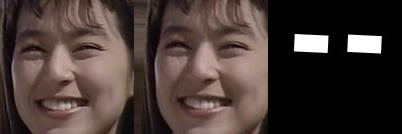

frame6090face0.jpg


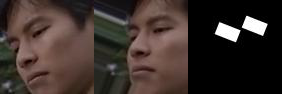

frame10032face0.jpg


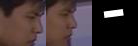

frame14214face0.jpg


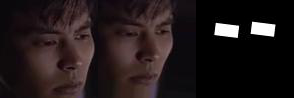

frame16470face0.jpg


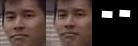

frame20190face0.jpg


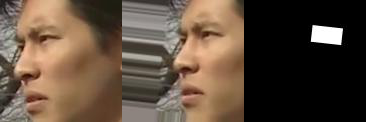

frame25512face0.jpg


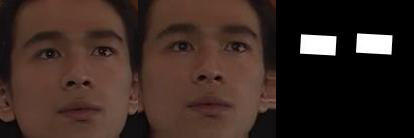

frame28602face0.jpg


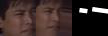

frame31848face1.jpg


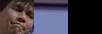

In [17]:
from utils import display_face_detection_result
display_face_detection_result('./faces', 10)